In [491]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [492]:
train_val_data = pd.read_csv("./Train_and_Validate_EEG.csv")
headers_before = train_val_data.columns.to_list()

train_val_data = train_val_data.dropna(axis=1, how='all')
headers_after = train_val_data.columns.to_list()

print(set(headers_before) - set(headers_after))

{'Unnamed: 122'}


In [493]:
# print(train_val_data.info())
train_val_data.describe(include='all')

,ID,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,852.000000,852,852.000000,852,839.000000,840.000000,852,852,852.000000,852.000000,...,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000
unique,NaN,2,NaN,666,NaN,NaN,7,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M,NaN,2013.1.17,NaN,NaN,Mood disorder,Depressive disorder,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,555,NaN,5,NaN,NaN,250,191,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,471.409624,NaN,30.548744,NaN,13.430274,101.396429,NaN,NaN,20.330829,21.312239,...,75.842007,54.983694,56.947577,60.557073,69.813658,47.847909,66.709123,39.249992,66.130099,56.903789
std,274.989580,NaN,11.738390,NaN,2.564135,17.085601,NaN,NaN,11.443365,12.417935,...,15.782265,19.511627,18.203185,17.744601,17.748133,19.598164,16.843523,20.843316,17.917650,19.604724
min,1.000000,NaN,18.000000,NaN,0.000000,49.000000,NaN,NaN,3.272260,3.244199,...,12.611954,0.519048,6.926792,2.214436,2.421748,0.036664,1.032207,1.228502,1.643951,4.340159
25%,230.750000,NaN,21.752500,NaN,12.000000,91.000000,NaN,NaN,12.772447,13.003745,...,68.067727,41.659341,44.045125,48.632636,59.196016,32.655800,56.154806,22.041208,54.987797,43.834643
50%,472.500000,NaN,26.010000,NaN,13.000000,102.000000,NaN,NaN,17.137013,17.930642,...,78.624002,55.105995,56.404859,61.108607,72.173855,45.701515,67.985444,36.305708,68.081346,57.180194
75%,710.250000,NaN,35.535000,NaN,16.000000,114.000000,NaN,NaN,24.816483,25.992534,...,87.165614,69.635095,70.607069,73.696268,83.026180,61.997235,78.736665,54.004810,78.978633,71.045497


In [494]:
train_val_counts = train_val_data.describe(include='all').iloc[0]
idx_hasna = train_val_counts[train_val_counts.apply(lambda x: int(x) != 852)].index

idx_hasna

Index(['education', 'IQ'], dtype='object')

In [495]:
rows_with_na_education = train_val_data[train_val_data['education'].isna()]
rows_with_na_iq = train_val_data[train_val_data['IQ'].isna()]

na_index = list(set(rows_with_na_education.index.to_list()).union(set(rows_with_na_iq.index.to_list())))
print(na_index)

[769, 707, 3, 199, 73, 587, 402, 537, 157, 226, 738, 803, 162, 227, 487, 804, 679, 362, 108, 242, 823, 250, 379, 316]


In [496]:
train_val_clean = train_val_data.drop(index=na_index)
train_val_clean.describe(include='all')

,ID,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,828.000000,828,828.000000,828,828.000000,828.000000,828,828,828.000000,828.000000,...,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000
unique,NaN,2,NaN,651,NaN,NaN,7,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M,NaN,2013.1.17,NaN,NaN,Mood disorder,Depressive disorder,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,539,NaN,5,NaN,NaN,246,188,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,471.657005,NaN,30.598152,NaN,13.435990,101.375604,NaN,NaN,20.367918,21.375176,...,75.972853,55.115058,56.993255,60.662168,70.025798,47.940380,66.904196,39.407460,66.289039,57.021100
std,274.566015,NaN,11.747058,NaN,2.570789,17.143543,NaN,NaN,11.537351,12.540608,...,15.757074,19.580062,18.261624,17.843551,17.700283,19.607299,16.808581,20.941359,17.922616,19.733269
min,1.000000,NaN,18.000000,NaN,0.000000,49.000000,NaN,NaN,3.272260,3.244199,...,12.611954,0.519048,6.926792,2.214436,2.421748,0.036664,1.032207,1.228502,1.643951,4.340159
25%,230.750000,NaN,21.835000,NaN,12.000000,91.000000,NaN,NaN,12.788493,13.003745,...,68.803249,41.659341,43.927332,48.780868,59.579014,32.655800,56.479459,22.006032,55.242184,43.834643
50%,474.500000,NaN,26.085000,NaN,13.000000,102.000000,NaN,NaN,17.107741,17.877864,...,78.762700,55.368414,56.694682,61.243097,72.473002,45.877296,68.250270,36.627840,68.418304,57.581482
75%,709.250000,NaN,35.587500,NaN,16.000000,114.000000,NaN,NaN,24.816483,26.193861,...,87.191115,69.666736,70.689085,73.797222,83.410553,62.154134,79.079525,54.169384,79.172126,71.643516


In [497]:
# but eeg.date might be useful

X = train_val_clean.drop(columns=['main.disorder', 'specific.disorder', 'ID', 'eeg.date'])
y = train_val_clean['main.disorder']

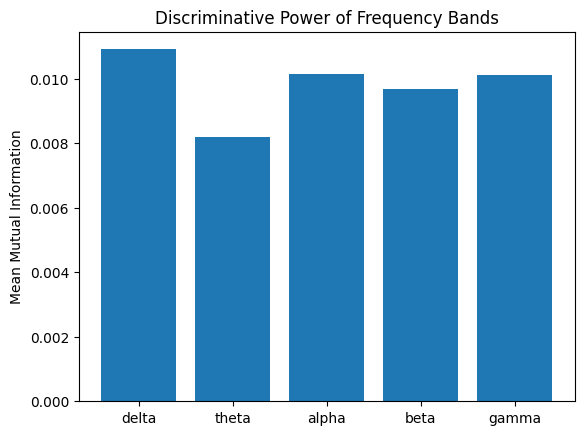

In [498]:
bands = {
    'delta': 'A', 
    'theta': 'B', 
    'alpha': 'C', 
    'beta': 'D', 
    'gamma': 'F'
}

selected_features = []

for band_name, band_code in bands.items():
    band_psd = [col for col in X.columns if f'AB.{band_code}' in col]
    band_coh = [col for col in X.columns if f'COH.{band_code}' in col]
    band_features = band_psd + band_coh

    selector = SelectKBest(score_func=mutual_info_classif, k=int(0.05 * len(band_features)))
    X_band = X[band_features]
    selector.fit(X_band, y)
    mask = selector.get_support()
    selected_features += X_band.columns[mask].tolist()

X_prioritized = X[selected_features]

# mutual info scores for bands
band_scores = {}
for band_name, band_code in bands.items():
    band_features = [col for col in X.columns if f'.{band_code}.' in col]
    mi_scores = mutual_info_classif(X[band_features], y)
    band_scores[band_name] = np.mean(mi_scores)

plt.bar(band_scores.keys(), band_scores.values())
plt.title("Discriminative Power of Frequency Bands")
plt.ylabel("Mean Mutual Information")
plt.show()

In [499]:
lobe_mapping = {
    'frontal': [('FP1','a'), ('FP2','b'), ('F3','d'), ('F4','f'), ('F7','c'), ('F8','g'), ('Fz','e')],
    'temporal': [('T3','h'), ('T4','l'), ('T5','m'), ('T6','q')],
    'central': [('C3','i'), ('C4','k'), ('Cz','j')],
    'parietal': [('P3','n'), ('P4','p'), ('Pz','o')],
    'occipital': [('O1','r'), ('O2','s')]
}


def compute_aggregates(X):
    X_new = X.copy()
    new_columns = {}

    # 1. lobe-specific mean PSD
    for band_code in bands.values():
        for lobe, electrodes in lobe_mapping.items():
            electrode_names = [elec[0] for elec in electrodes]

            psd_cols = [col for col in X.columns 
                        if f'AB.{band_code}' in col 
                        and any(elec in col for elec in electrode_names)]
            if psd_cols:
                new_columns[f'lobe_{lobe}_band_{band_code}_mean_psd'] = X[psd_cols].mean(axis=1)

    # 2. hemispheric asymmetry
    for band_name, band_code in bands.items():
        for left, right in [(('FP1','a'), ('FP2','b')), (('F3','d'), ('F4','f')), (('F4','f'), ('F8','g')), (('T3','h'), ('T4','l')), (('C3','i'), ('C4','k')), (('T5','m'), ('T6','q')), (('P3','n'), ('P4','p')), (('O1','r'), ('O2','s'))]:
            left_col = f'AB.{band_code}.{band_name}.{left[1]}.{left[0]}'
            right_col = f'AB.{band_code}.{band_name}.{right[1]}.{right[0]}'
            new_columns[f'asym_{left[0]}_{right[0]}_band_{band_code}'] = (
                X[left_col] - X[right_col]
            ) / (X[left_col] + X[right_col] + 1e-6)
    
    # 3. within-lobe connectivity
    for band_code in bands.values():
        for lobe, electrodes in lobe_mapping.items():
            electrode_names = [elec[0] for elec in electrodes]
            coh_cols = [col for col in X.columns 
                        if f'COH.{band_code}' in col 
                        and any(e in col for e in electrode_names)]
            if coh_cols:
                new_columns[f'lobe_{lobe}_band_{band_code}_mean_coh'] = X[coh_cols].mean(axis=1)

    # 4. global mean coherence for each band
    for band_code in bands.values():
        coh_cols = [col for col in X.columns if f'COH.{band_code}' in col]
        if coh_cols:
            new_columns[f'global_band_{band_code}_mean_coh'] = X[coh_cols].mean(axis=1)
    
    # 5. frontal vs. occipital PSD asymmetry
    for band_code in bands.values():
        frontal_col = f'lobe_frontal_band_{band_code}_mean_psd'
        occipital_col = f'lobe_occipital_band_{band_code}_mean_psd'
        if frontal_col in X_new.columns and occipital_col in X_new.columns:
            new_columns[f'asym_frontal_occipital_band_{band_code}'] = (
                X_new[frontal_col] - X_new[occipital_col]
            ) / (X_new[frontal_col] + X_new[occipital_col] + 1e-6)
    
    
    new_columns_df = pd.DataFrame(new_columns)
    X_new = pd.concat([X_new, new_columns_df], axis=1)
    
    return X_new

# pending: Critical Coherence Pairs

In [500]:
# Single Classed Classification
X_aggregated = compute_aggregates(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_stage1 = (y == 'Mood disorder').astype(int)

X_aggregated['sex'] = X_aggregated['sex'].map({'M': 1, 'F': 0})

X_train, X_val, y_train, y_val = train_test_split(X_aggregated, y_stage1, test_size=0.3, random_state=42)

engineered_features = X_aggregated.columns[4:].tolist()
num_features = ['age', 'education', 'IQ'] + engineered_features

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_val_scaled[num_features] = scaler.transform(X_val[num_features])

model = RandomForestClassifier(
    random_state=42,
    max_depth=2,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    n_jobs=-1,
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled)

print(classification_report(y_val, y_pred, target_names=['Not Mood Disorder', 'Mood Disorder']))

                   precision    recall  f1-score   support

Not Mood Disorder       0.71      1.00      0.83       177
    Mood Disorder       0.00      0.00      0.00        72

         accuracy                           0.71       249
        macro avg       0.36      0.50      0.42       249
     weighted avg       0.51      0.71      0.59       249



/opt/conda/envs/project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# MULTI_LABEL CLASSIFICATION

X_aggregated = compute_aggregates(X)
X_aggregated['sex'] = X_aggregated['sex'].map({'M': 1, 'F': 0})

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_val, y_train, y_val = train_test_split(X_aggregated, y_encoded, test_size=0.2, random_state=42)

engineered_features = X_aggregated.columns[4:].tolist()
num_features = ['age', 'education', 'IQ'] + engineered_features

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_features)]
)

X_train_transformed = preprocessor.fit_transform(X_train)

X_val_transformed = preprocessor.transform(X_val)

# Grid Searched
model = RandomForestClassifier(random_state=42, max_depth=2, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)

model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)

print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

                                    precision    recall  f1-score   support

                Addictive disorder       0.18      0.10      0.12        31
                  Anxiety disorder       0.00      0.00      0.00        17
                   Healthy control       0.00      0.00      0.00        20
                     Mood disorder       0.32      0.96      0.47        49
     Obsessive compulsive disorder       0.00      0.00      0.00         8
                     Schizophrenia       0.00      0.00      0.00        23
Trauma and stress related disorder       0.00      0.00      0.00        18

                          accuracy                           0.30       166
                         macro avg       0.07      0.15      0.09       166
                      weighted avg       0.13      0.30      0.16       166



/opt/conda/envs/project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [502]:
X_aggregated = compute_aggregates(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_stage1 = (y == 'Mood disorder').astype(int)

X_aggregated['sex'] = X_aggregated['sex'].map({'M': 1, 'F': 0})

X_train, X_val, y_train, y_val = train_test_split(X_aggregated, y_stage1, test_size=0.3, random_state=42)

engineered_features = X_aggregated.columns[4:].tolist()
num_features = ['age', 'education', 'IQ'] + engineered_features


scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_val_scaled[num_features] = scaler.transform(X_val[num_features])


X_train_tensor = torch.tensor(X_train_scaled.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_scaled.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [503]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

input_dim = X_train_tensor.shape[1]
model = MLP(input_dim)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            
            predicted = (outputs >= 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_accuracy:.4f}")

Epoch [1/1000] Train Loss: 0.6887 Val Loss: 0.6842 Val Acc: 0.6225
Epoch [2/1000] Train Loss: 0.6881 Val Loss: 0.6832 Val Acc: 0.6386
Epoch [3/1000] Train Loss: 0.6803 Val Loss: 0.6819 Val Acc: 0.6707
Epoch [4/1000] Train Loss: 0.6788 Val Loss: 0.6809 Val Acc: 0.6667
Epoch [5/1000] Train Loss: 0.6785 Val Loss: 0.6801 Val Acc: 0.6747
Epoch [6/1000] Train Loss: 0.6793 Val Loss: 0.6792 Val Acc: 0.6667
Epoch [7/1000] Train Loss: 0.6794 Val Loss: 0.6782 Val Acc: 0.6707
Epoch [8/1000] Train Loss: 0.6797 Val Loss: 0.6772 Val Acc: 0.6707
Epoch [9/1000] Train Loss: 0.6777 Val Loss: 0.6761 Val Acc: 0.6667
Epoch [10/1000] Train Loss: 0.6804 Val Loss: 0.6752 Val Acc: 0.6667
Epoch [11/1000] Train Loss: 0.6746 Val Loss: 0.6745 Val Acc: 0.6707
Epoch [12/1000] Train Loss: 0.6648 Val Loss: 0.6736 Val Acc: 0.6787
Epoch [13/1000] Train Loss: 0.6675 Val Loss: 0.6727 Val Acc: 0.6747
Epoch [14/1000] Train Loss: 0.6693 Val Loss: 0.6721 Val Acc: 0.6827
Epoch [15/1000] Train Loss: 0.6642 Val Loss: 0.6714 Val A

In [504]:
# # domain knowledge from literature
# critical_pairs = {
#     'schizophrenia': ['Fz-Pz', 'F3-F4'],
#     'mood_disorder': ['F3-P3', 'F4-P4'],
#     'addictive_disorder': ['F7-F8']
# }